### NMR shieldings
* Moleküleingabe aus sdf Datei, Suche nach Namen der der NMRShiftDB - ID entspricht
* DFT Geometrie aus der sdf- Datei übernehmen
* Berechnung anisotroper Verschiebung
* verbesserte Ausgaben
* Export in Excel


2024.03.5


[18:30:51] Warning: molecule is tagged as 3D, but all Z coords are zero and 2D stereo markers have been found, marking the mol as 2D.


Eintrag gefunden


[18:30:52] Warning: molecule is tagged as 3D, but all Z coords are zero and 2D stereo markers have been found, marking the mol as 2D.
[18:30:52] Warning: molecule is tagged as 3D, but all Z coords are zero and 2D stereo markers have been found, marking the mol as 2D.
[18:30:52] Warning: molecule is tagged as 3D, but all Z coords are zero and 2D stereo markers have been found, marking the mol as 2D.
[18:30:52] Warning: molecule is tagged as 3D, but all Z coords are zero and 2D stereo markers have been found, marking the mol as 2D.


XYZ-Datei xyz/id10016898_dft.xyz wurde erfolgreich erstellt.
Die Datei existiert.
Die Datei "bilder/id10016898_dft.png" existiert nicht.


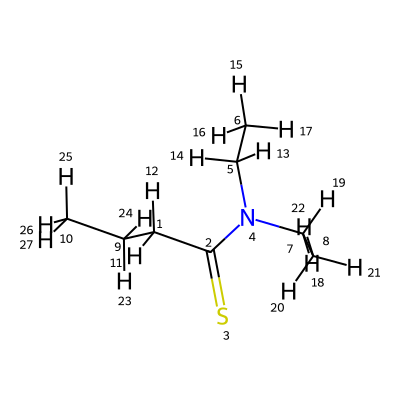

Starte Berechnung
output file: logs/id10016898_dft.log
Walltime: 31.77047061920166 Sekunden
Programm kann fortgesetzt werden!


In [29]:
#####################################
#
# Computing NMR shielding constants
#
######################################
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image, display, HTML, clear_output
import pandas as pd
import pyscf
from pyscf import gto, dft
from pyscf.prop import nmr
from pathlib import Path
import sys,time,os
import pubchempy  # zur Namensgenerierung wenn kein Name vorhanden ist
from openpyxl import Workbook, load_workbook  # zum Manipulieren der Excel Datei
print(rdkit.__version__)


######## NMR Shift ID eingeben ###############

nmrshift_id = '10016898'    # ist der Suchbegriff und steht als Molekülname in der SDF datei, String damit der Vergleich klappt

jobname = f"id{nmrshift_id}"
size=(400,400)   # definiert die Größe der Abbildung
# Filename vom Jobnamen bilden
xyzin =f"xyz/{jobname}_dft.xyz"
logfile=f"logs/{jobname}_dft.log"
bilddatei=f"bilder/{jobname}_dft.png"
mols = Chem.SDMolSupplier("DFT-geometrien.sdf", removeHs=False)    # Name der SDF Datei die eingelesen wird

#Suche nach dem Namen
nicht_gefunden =True   
for mol in mols:
    eintragsname=mol.GetProp("_Name")
    if eintragsname==nmrshift_id:
        molin=mol # molin wird auf gefundenen Eintrag gesetzt
        print('Eintrag gefunden')
        nicht_gefunden = False
if nicht_gefunden: 
    print('Eintrag nicht gefunden')
    sys.exit(1)

# 3D-Koordinaten generieren sollte nicht notwendig sein. Ich will genau die DFT Koordinaten verwenden
#AllChem.EmbedMolecule(molin)  # 3D-Einbettung

#### Excel- Ausgabe vorbereiten #####
excel ="testmappe3.xlsx"    # Name der Excel Datei
# definiere die Blattnamen
blatt1name='Allgemein'  # Arbeitsblatt für die Moleküldaten

# Lade die Excel- Datei
wb = load_workbook(excel)
blatt1 = wb[blatt1name]


# XYZ-Datei speichern (wie bisher um nicht zu sehr in den Ablauf einzugreifen)
Chem.MolToXYZFile(molin, xyzin)
print(f"XYZ-Datei {xyzin} wurde erfolgreich erstellt.")

dateipfad = Path(xyzin)

if dateipfad.exists():
    print("Die Datei existiert.")
else:
    print("Die Datei existiert nicht.")
    sys.exit(1)

if molin is not None:  
    # Biddatei generieren und falls vorhanden vorher löschen, 
    # Überprüfen, ob die Datei existiert, wenn ja löschen
    if os.path.isfile(bilddatei):
        print(f'Die Datei "{bilddatei}" existiert.')
    
        # Datei löschen
        os.remove(bilddatei)
        print(f'Die Datei "{bilddatei}" wurde gelöscht.')
    else:
        print(f'Die Datei "{bilddatei}" existiert nicht.')
    for atom in molin.GetAtoms():
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", str(atom.GetIdx()+1))
    image= Chem.Draw.MolToImage(molin, size=size)
    image.save(bilddatei)
    properties = molin.GetPropsAsDict()  #Alle in der SDF gespeicherten Eigenschaften einlesen

display(image)
print("Starte Berechnung")

start_time = time.time()

mol = pyscf.M(atom=xyzin, basis='6-31g*', output=logfile)

mf = dft.RKS(mol)
mf.xc = 'b3lyp'
mf.run()

#nmr.RKS(mf).kernel()

abschirmung = nmr.RKS(mf).kernel()

end_time = time.time()
print(f'Walltime: {end_time-start_time} Sekunden')
print("Programm kann fortgesetzt werden!")

In [30]:
# 3D-Darstellung  erzeugen

size2=(600,600)
mol2=molin
AllChem.EmbedMolecule(mol2)

Chem.Draw.IPythonConsole.drawMol3D(mol2,drawAs='stick', bgColor='yellow', size=size2) #sphere anstelle stick funktioniert auch

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [31]:
#################################################################################################
#
# Constanten für Verschiebungsberchnung
#
# CSHESHIRE Repository (Tantillo)
#
# Table 1a and 1b
#
# delta = (intercept -sigma)/ - slope
#
# Das Vorzeichen von slope wird gleich in die Definition der Konstanten eingepflegt
#
# TMS shielding aus eigener Berechnung delta = sigma - TMS
#
# Der 1H Teil ist auskommentiert drinn gelassen
#
##################################################################################################

intercept1a = 187.4743
slope1a = 0.9269
intercept1b = 188.4418
slope1b = 0.9449
intercept1c = 188.01
slope1c = 0.9378
tmsshield = 190.2218


shift = [0] *mol.natm
shift1a = [0] *mol.natm
shift1b= [0] *mol.natm
shift1c= [0] *mol.natm
shifttms= [0] *mol.natm


data = []

for i in range(mol.natm):
    shift[i]= (abschirmung[i,0,0] + abschirmung[i,1,1] + abschirmung[i,2,2])/3
    #print(f"Atom {mol._atom[i][0]} {i} hat eine totale Abschirmung von {shift[i]} .")
    if  mol._atom[i][0] =='C':
        shift1a[i] = round(((intercept1a-shift[i])/slope1a),2)
        shift1b[i] = round(((intercept1b-shift[i])/slope1b),2)
        shift1c[i] = round(((intercept1c-shift[i])/slope1c),2)
        shifttms[i] = round((tmsshield - shift[i]),2)      
        data.append({'Atom': mol._atom[i][0], 'Index': i+1, 'Totale Abschirmung': shift[i], 'table1a': shift1a[i], 'table1b' : shift1b[i], 'table1c' : shift1c[i], 'TMS' : shifttms[i]})

# Erstelle ein DataFrame
df2 = pd.DataFrame(data)

# Setze die Spaltenüberschriften
df2.columns = ['Atom', 'Index', 'Totale Abschirmung', 'table1a', 'table1b', 'table1c', 'TMS']


# Verwende Styler, um die Schriftgröße zu ändern
styled_df = df2.style.set_table_attributes('style="font-size: 17px;"')  # Ändere die Schriftgröße hier

from IPython.display import Image, display

# Zeige die Tabelle an
display(HTML(f"<h2 style=color:#069>berechnete Verschiebungen</h2>"))
display(styled_df)
#display(Image(filename=bilddatei))

,Atom,Index,Totale Abschirmung,table1a,table1b,table1c,TMS
0,C,1,144.591909,46.260000,46.410000,46.300000,45.630000
1,C,2,-4.977140,207.630000,204.700000,205.790000,195.200000
2,C,5,146.336501,44.380000,44.560000,44.440000,43.890000
3,C,6,176.863078,11.450000,12.250000,11.890000,13.360000
4,C,7,144.735758,46.110000,46.250000,46.140000,45.490000
5,C,8,180.510024,7.510000,8.390000,8.000000,9.710000
6,C,9,163.938845,25.390000,25.930000,25.670000,26.280000
7,C,10,175.593663,12.820000,13.600000,13.240000,14.630000


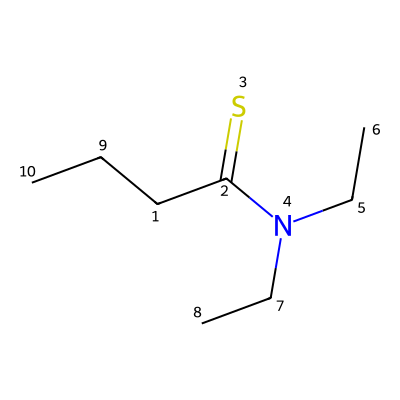

In [32]:
#display(image)
d2mol=Chem.MolFromXYZFile(xyzin)
# Bindungen automatisch bestimmen
rdDetermineBonds.DetermineBonds(d2mol)
d2mol=Chem.RemoveHs(d2mol)
# 2D-Koordinaten berechnen
AllChem.Compute2DCoords(d2mol)

for d2atom in d2mol.GetAtoms():
        # For each atom, set the property "atomNote" to a index+1 of the atom
        d2atom.SetProp("atomNote", str(d2atom.GetIdx()+1))

# Molekül zeichnen
img = Draw.MolToImage(d2mol,size=size)
#img.show()
display(img)

In [33]:
####################################################################################
#                                                                                  #
#     atomare Descriptoren berechnen                                               #
#                                                                                  #
####################################################################################

hybrid = [""] *mol.natm             # zum Speichern des Hybridisierungszustandes
gas_charge = [0] *mol.natm          # zum Speichern der Gasteiger Ladungen
schwefel_direkt = ['No'] *mol.natm  # direkt gebundener Schwefel
chlor_direkt = ['No'] *mol.natm     # direkt gebundenes Chlor
brom_direkt = ['No'] *mol.natm      # direkt gebundenes Brom
chiral_symbol =['None'] *mol.natm   # Chiralität
aromatisch =['No'] *mol.natm        # ist das Atom aromatisch


# grundlegende Schleife

for i in range(mol.natm):
    if  mol._atom[i][0] =='C':
        # Atomobjekt abrufen
        atom = mol2.GetAtomWithIdx(i)

        # Hybridisierung abrufen
        hybridization = atom.GetHybridization()
        hybrid[i] = hybridization

### Gasteiger Charges
m2 =Chem.Mol(molin)
AllChem.ComputeGasteigerCharges(m2)
for atom in m2.GetAtoms():
    lbl = '%.2f'%(atom.GetDoubleProp("_GasteigerCharge"))
    atom.SetProp('atomNote',lbl)

# Molekül zeichnen
#img2 = Draw.MolToImage(m2 ,size=size)
#display(img2)


i=0
for atom in m2.GetAtoms():
    charge='%.2f'%(atom.GetDoubleProp("_GasteigerCharge"))
    gas_charge[i] = charge
    #if atom.GetAtomicNum()==6:
    #      print(f"Atom-Nr.: {i+1} Gasteiger-Ladung: {charge}")
    i=i+1



#### Atombindungen feststellen

# Schleife über alle Atome

i=0
for atom in m2.GetAtoms():
    atom = m2.GetAtomWithIdx(i)
    if atom.GetAtomicNum()==6:    # nur dann betrahten, wenn es ein C-Atom ist
        # Abrufen der Bindungen des Atoms
        bonds = atom.GetBonds()
        # print(f"Bindungen von Atom- Nummer: {atom_nummer}")

        # Ausgabe der Bindungen
        for bond in bonds:
            #print(f'Bindung {bond.GetBeginAtomIdx()+1} und {bond.GetEndAtomIdx()+1} ist vom Typ {bond.GetBondType()}')
            start_index = bond.GetBeginAtomIdx()
            end_index = bond.GetEndAtomIdx()
            atom2=m2.GetAtomWithIdx(start_index)
            atom3=m2.GetAtomWithIdx(end_index)
            if (start_index!=i) and (atom2.GetAtomicNum() ==16):
                    print(f"Atom- Nummer {i+1} ist direkt an Schwefel gebunden")
                    schwefel_direkt[i]='Yes'
            if (end_index!=i) and (atom3.GetAtomicNum() ==16):
                    print(f"Atom- Nummer {i+1} ist direkt an Schwefel gebunden")
                    schwefel_direkt[i]='Yes'
            if (start_index!=i) and (atom2.GetAtomicNum() ==17):
                    print(f"Atom- Nummer {i+1} ist direkt an Chlor gebunden")
                    chlor_direkt[i]='Yes'
            if (end_index!=i) and (atom3.GetAtomicNum() ==17):
                    print(f"Atom- Nummer {i+1} ist direkt an Chlor gebunden")
                    chlor_direkt[i]='Yes'
            if (start_index!=i) and (atom2.GetAtomicNum() ==35):
                    print(f"Atom- Nummer {i+1} ist direkt an Schwefel gebunden")
                    brom_direkt[i]='Yes'
            if (end_index!=i) and (atom3.GetAtomicNum() ==35):
                    print(f"Atom- Nummer {i+1} ist direkt an Schwefel gebunden")
                    brom_direkt[i]='Yes'

    i=i+1


# Chiralitäten und Aromatizität feststellen
i=0
for atom in m2.GetAtoms():
    chiral_tag =f"{atom.GetChiralTag()}"
    if atom.GetIsAromatic(): aromatisch[i]="yes"
    if chiral_tag =='CHI_TETRAHEDRAL_CCW' : 
        chiral_symbol[i] ='CCW'    # sollte S sein, ist mir aber sicherer so
    if chiral_tag =='CHI_TETRAHEDRAL_CW' : 
        chiral_symbol[i] ='CW'
    if (atom.GetAtomicNum()==6) and (chiral_symbol[i]!='None'):
          print(f"Atom-Nr.: {i+1} Chiralität: {chiral_symbol[i]}")
    i=i+1


Atom- Nummer 2 ist direkt an Schwefel gebunden


In [34]:
###########################################################################
#                                                                         #
#         Die Excel Ausgabe ab hier in einem Schritt                      #
#                                                                         #
###########################################################################

# Erst mal noch Summenformel und Name bestimmen
# steht der Name nicht in der SDF datei wird versucht diesen aus pubchem durch SMILES Abfrage zu erhalten

# molin ist das rdkit mol Objekt !!
molekuel_name =""
NMRid = nmrshift_id

if len(molekuel_name) == 0:
    print("Der Molekülname ist leer. Versuche pubchem als Quelle!")
    # Use the SMILES you provided
    smiles = Chem.MolToSmiles(molin)
    compounds = pubchempy.get_compounds(smiles, 'smiles')
    match = compounds[0]
    molekuel_name = match.iupac_name
    print(molekuel_name)
    print(smiles)
else:
    print(f"Molekülname: {molekuel_name}")

# Generiere die Summenformel
summenformel = Chem.rdMolDescriptors.CalcMolFormula(molin)
print("Summenformel:", summenformel)

# Daten in Excel schreiben und manipulieren
# Die Dokumentation von openpyxl ist grauenvoll
# monica.im hilft


##############################################################
#
# Struktur Blatt 1
#
# Spalte A = NMRshiftDB-ID
# Spalte B = Molekülname
# Spalte C = SMILES
# Spalte D = Summenformel
#
#ä#############################################################


blatt2name='13c-daten'  # Arbeitsblatt mit den 13C chemischen Verschiebungen 


#######################################################################################
#
# Struktur Blatt 2
#
# Spalte A = NMRshiftDB-ID
# Spalte B = C-Atom Nummer
# Spalte C = (bleibt leer zum nachkopieren)
# Spalte D = total shielding
# Spalte D2 = Hybridisierung
# Spalte D4 = direkt gebundener Schwefel
# Spalte D5 = direkt gebundenes Chlor
# Spalte D6 = direkt gebundenes Brom
# Spalte D7 = chiral
# SPalte D7 = aromatisch
# Spalte D3 = Gasteiger Ladungen
# Spalte E = berechnete Verschiebung Methode 1  (CSHESHIRE Gasphase)
# Spalte F = berechnete Verschiebung Methode 2  (CDCl3 Solventmodell SMD  )
# Spalte G = berechnete Verschiebung Methode 3  (CDCl3 Solventmodell CPCM/UAKS ) 
# Spalte H = berechnete Verschiebung Methode 4  (klassisch gegen TMS)
#
#########################################################################################



blatt2 = wb[blatt2name]

#########################################
#                                       #
# Suche nach den ersten leeren Zeilen   #
#                                       #
#########################################


# Funktion, um die erste leere Zeile zu finden
def finde_erste_leere_zeile(blatt):
    for zeile in range(1, blatt.max_row + 2):  # +2, um die nächste Zeile nach der letzten zu überprüfen
        if all(cell.value is None for cell in blatt[zeile]):
            return zeile
    return None  # Falls keine leere Zeile gefunden wird

# Finde die erste leere Zeile
erste_leere_zeile1 = finde_erste_leere_zeile(blatt1)
erste_leere_zeile2 = finde_erste_leere_zeile(blatt2)

if erste_leere_zeile1:
    print(f'Die erste leere Zeile in {blatt1name} ist: {erste_leere_zeile1}')
else:
    print('Keine leere Zeile gefunden.')
    
if erste_leere_zeile2:
    print(f'Die erste leere Zeile in {blatt2name} ist: {erste_leere_zeile2}')
else:
    print('Keine leere Zeile gefunden.')

    
# Füge die allgemeinen Daten in die erste leere Zeile von Blatt1 ein
if erste_leere_zeile1:
    blatt1[f'A{erste_leere_zeile1}'] = NMRid
    blatt1[f'B{erste_leere_zeile1}'] = molekuel_name
    blatt1[f'C{erste_leere_zeile1}'] = smiles
    blatt1[f'D{erste_leere_zeile1}'] = summenformel
    

# Jetzt das zweite Blatt mit den Atomdaten

#print(f"{'NMRid':<10} {'Atom-Nr.':<10} {'expShift':<10} {'hybrid'} {'G-Charge':<10} {'shift':<10} {'shift1a':<10} {'shift1b':<10} {'shift1c':<10} {'shifttms':<10}")
expShift=""  #exp. Verschiebung muss nachgetragen werden da nicht in sdf enthalten
for i in range(mol.natm):
    if  mol._atom[i][0] =='C':
        # Ausgabe in Spalten formatieren
        #print(f"{NMRid:<10} {(i+1):<10} {expShift[i]:<10} {hybrid[i]} {gas_charge[i]:<10} {float(shift[i]):<10.6f} {shift1a[i]:<10} {shift1b[i]:<10} {shift1c[i]:<10} {shifttms[i]:<10}")
        hyb =(f"{hybrid[i]}")
        
        data = [
            NMRid,
            i + 1,
            expShift,  
            hyb,
            schwefel_direkt[i],
            chlor_direkt[i],
            brom_direkt[i],
            chiral_symbol[i],
            aromatisch[i],
            float(gas_charge[i]),
            float(shift[i]),
            float(shift1a[i]),
            float(shift1b[i]),
            float(shift1c[i]),
            float(shifttms[i])
        ]
        blatt2.append(data)
        #print(data)

#speichere die Datei am Ende sobald ich was daran manipuliere
wb.save(excel)
print()
print("Alles Berechnungen und Einträge abgeschlossen")
# Aktuelle Zeit in Sekunden seit dem Epoch (1. Januar 1970)
timestamp = time.time()

# Umwandlung in lokale Zeit
local_time = time.localtime(timestamp)

# Formatierung der Zeit
formatted_time = time.strftime("%H:%M:%S", local_time)

print(f"Aktuelle Uhrzeit: {formatted_time}")

Der Molekülname ist leer. Versuche pubchem als Quelle!
N,N-diethylbutanethioamide
[H]C([H])([H])C([H])([H])N(C(=S)C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H]
Summenformel: C8H17NS
Die erste leere Zeile in Allgemein ist: 77
Die erste leere Zeile in 13c-daten ist: 938

Alles Berechnungen und Einträge abgeschlossen
Aktuelle Uhrzeit: 18:31:25


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Parameter für das Signal
fs = 44100  # Abtastrate
f = 440.0   # Frequenz des Signals (A4)
duration = 2.0  # Dauer in Sekunden

# Erzeuge die Zeitachse
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Erzeuge das akustische Signal (Sinuswelle)
signal = 0.5 * np.sin(2 * np.pi * f * t)

# Spiele das Signal ab
Audio(signal, rate=fs, autoplay=True)
